# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [3]:
from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging,
                           perform_experiments)

from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.evaluators import SequentialEvaluator


In [4]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)

    model = ExcelModel("predatorPrey", wd="C:/Users/Ashok/Documents/EPA/EPA Q4/Model-Based Decision Making/Week1/model",
                       model_file='PredPrey.xlsx')
    model.uncertainties = [RealParameter("K2", 0.01, 0.2),  # we can refer to a cell in the normal way
                           # we can also use named cells
                           RealParameter("prey_birth_rate", 0.015, 0.035),
                           RealParameter("predation_rate", 0.0005, 0.003),
                           RealParameter("predator_efficiency", 0.001, 0.004),
                           RealParameter("predator_loss_rate", 0.04, 0.08)]                       

    # specification of the outcomes
    model.outcomes = [TimeSeriesOutcome("B17:BDF17"),  # we can refer to a range in the normal way
                      TimeSeriesOutcome("B18:BDF18")]  # we can also use named range

    # name of the sheet
    model.default_sheet = "Sheet1"

  #  with SequentialEvaluator(model) as evaluator:
     #   experminets,  outcomes = perform_experiments(model, 100, reporting_interval=1,
      #                                evaluator=evaluator)


In [5]:
from ema_workbench import SequentialEvaluator
#ema_logging.log_to_stderr(ema_logging.INFO)
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [25]:

experiments, outcomes = results
print(experiments.shape)
print(list(outcomes.keys()))

(100, 8)
['B17:BDF17', 'B18:BDF18']


In [26]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies

ValueError: If using all scalar values, you must pass an index

[MainProcess/INFO] no time dimension found in results


AttributeError: 'NoneType' object has no attribute 'T'

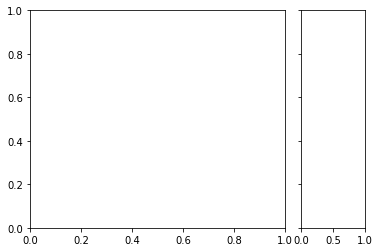

In [27]:
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()

Vensim Model

In [28]:
from __future__ import (division, unicode_literals, absolute_import,
                        print_function)

from ema_workbench import (TimeSeriesOutcome, perform_experiments,
                           RealParameter, ema_logging)

from ema_workbench.connectors.vensim import VensimModel

if __name__ == "__main__":
    # turn on logging
    ema_logging.log_to_stderr(ema_logging.INFO)

    # instantiate a model
    wd = r'C:/Users/Ashok/Documents/EPA/EPA Q4/Model-Based Decision Making/Week1/model'
    vensimModel = VensimModel("VensimPredPrey", wd=wd,
                              model_file=r'\PredPrey.vpm')
    vensimModel.uncertainties = [RealParameter("x11", 0, 2.5),
                                 RealParameter("x12", -2.5, 2.5)]

    vensimModel.outcomes = [TimeSeriesOutcome('a')]

    results = perform_experiments(vensimModel, 1000, parallel=True)

ImportError: vensim dll not found